**Aims**:
 - extract the omics mentioned in multi-omics articles

In [1]:
%run notebook_setup.ipynb

In [2]:
import pandas
pandas.set_option('display.max_colwidth', 100)

In [3]:
%vault from pubmed_derived_data import literature

Imported `literature` (E4FB4141) at Thursday, 23. Jul 2020 17:25

In [4]:
has_abstract = ~literature['abstract'].isnull()

**TODO: use title if not abstract, add keywords, use full text if available**

In [5]:
literature['abstract_clean'] = literature['abstract_clean'].fillna('')

In [6]:
omics_features = literature.index.to_frame().copy()

In [7]:
from functools import partial
from helpers.text_processing import check_usage
from pandas import Series

check_usage_in_abstracts = partial(check_usage, data=literature, column='abstract_clean')

In [8]:
TERM_IN_AT_LEAST_N_ARTICLES = 5

# Omics

## 1. Lookup by words which end with -ome

In [9]:
organelles = {
    'peroxisome',
    'proteasome',
    'ribosome',
    'exosome',
    'nucleosome'
}

In [10]:
note_an_ome = {
    'outcome',
    'some',
    'become',
    'home',
    'come',
    'chromosome',
    'overcome',
    'cytochrome',
    'syndrome',
    'reactome',
    *organelles
}

In [11]:
from omics import get_ome_regexp
ome_re = get_ome_regexp()
get_ome_regexp??

Signature: get_ome_regexp() -> str
Docstring: <no docstring>
Source:   
def get_ome_regexp() -> str:
    return (
        # use look-ahead to allow for overlaps
        '(?='
            rf'(?:^|\s|{separators_re}|ome-)'
            '('
                r'(?:\w+)ome'
                '|'
                r'(?:(?:\w+-\w*)|\w+)ome'
            ')'
            # also, match plural form
            '(?:s)?'
            rf'(?:\s|$|{separators_re}|-)'
        ')'
    )
File:      ~/multi-omics/omics.py
Type:      function


In [12]:
ome_occurrences = (
    literature['abstract_clean'].str.lower()
    .str.extractall(ome_re)[0]
    .to_frame('term').reset_index()
)
ome_occurrences = ome_occurrences[~ome_occurrences.term.isin(note_an_ome)]
ome_occurrences.head(3)

,uid,match,term
2,15687839,1,genome
7,16611894,0,genome
9,16935752,0,genome


### 1.2 Fix typos

In [13]:
from helpers.text_processing import find_term_typos, create_typos_map

In [14]:
ome_counts = ome_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
potential_ome_typos = find_term_typos(ome_counts, TERM_IN_AT_LEAST_N_ARTICLES - 1)
potential_ome_typos

,rare_term,popular_term,similarity
0,phospho-proteome,phosphoproteome,0.967742
1,mirnaome,mirnome,0.933333
2,mirome,mirnome,0.923077


In [15]:
check_usage_in_abstracts('miRNAome')

uid
25783038    stemic responses of gut hormones, the circulating miRNAome and the metabolome in a rat model of ...
29312565    hts. Here, we performed an integrated analysis of miRNAome, proteome and metabolome, aimed to in...
Name: abstract_clean, dtype: object

In [16]:
is_typo_subset_or_variant = {
    ('phospho-proteome', 'phosphoproteome'): True,
    ('mirnaome', 'mirnome'): True,
    ('mirome', 'mirnome'): True
}
ome_typos_map = create_typos_map(potential_ome_typos, is_typo_subset_or_variant)

In [17]:
replaced = ome_occurrences.term[ome_occurrences.term.isin(ome_typos_map)]
replaced.value_counts()

mirnaome            2
mirome              1
phospho-proteome    1
Name: term, dtype: int64

In [18]:
len(replaced)

4

In [19]:
ome_occurrences.term = ome_occurrences.term.replace(ome_typos_map)

### 1.3 Popular \*ome terms

In [20]:
ome_counts = ome_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
ome_counts[ome_counts >= TERM_IN_AT_LEAST_N_ARTICLES]

index
genome                 763
transcriptome          311
proteome               230
microbiome             181
metabolome             177
exome                   51
epigenome               49
whole-genome            48
methylome               30
metagenome              24
whole-exome             23
interactome             20
phenome                 18
phosphoproteome         17
lipidome                14
secretome               13
metatranscriptome       10
translatome              9
whole-transcriptome      8
exposome                 6
mirnome                  6
host-microbiome          5
metaproteome             5
Name: term, dtype: int64

### 2. Lookup by omics and adjectives

In [21]:
from omics import get_omics_regexp

omics_re = get_omics_regexp()
get_omics_regexp??

Signature: get_omics_regexp() -> str
Docstring: <no docstring>
Source:   
def get_omics_regexp() -> str:
    return (
        # use look-ahead to allow for overlaps
        '(?='
            rf'(?:^|\s|{separators_re}|omic-)'
            # match '*-omic', '*-*omic', '*omic'
            '('
                # handle both *omic-*omic and *-*omic
                r'(?:\w+)omic'
                '|'
                r'(?:(?:\w+-\w*)|\w+)omic'
            ')'
            # match both *omic and omics, but capture only "omic" part
            '(?:s)?'
            rf'(?:\s|$|{separators_re}|-)'
        ')'
    )
File:      ~/multi-omics/omics.py
Type:      function


In [22]:
check_usage_in_abstracts('integromics')

uid
23105932    endium and integrative omics analyses, so-called "integromics", have extended our understanding ...
24299457    rmacological response mechanisms. By means of an "integromics" network approach, we assessed the...
25887273                                  \nThe avalanche of integromics and panomics approaches shifted the de
27255914    l explore the essential elements of assembling an integromics framework from a more detailed per...
31126983    on of these orthogonal data sets, perhaps called "integromics." We highlight examples of recent ...
Name: abstract_clean, dtype: object

In [23]:
check_usage_in_abstracts('meta-omics')

uid
19837627    s on metabolomics data management, normalization, meta-omics data analysis, and an integrative a...
26315987    nd us through the application of high-resolution "meta-omics". Metaproteomics offers the ability...
28744486    odontal ligament and alveolar bone. We employed a meta-omics approach that included microbial 16...
29427518    ast few years, the application of high-throughput meta-omics methods has provided great progress...
29656009    enomics, transcriptomics, proteomics metabolomics meta-omics and combined omics as powerful stra...
30285475    per reviews studies in which application of these meta-omics technologies has led to a better un...
30728080    onomas sp. alone.\n\n\nThe three types of integrated meta-omics analyses effectively revealed th...
30945796    oding data sets were integrated in a multivariate meta-omics analysis (multi-block PLS-DA from t...
31186307    niches of constituent populations, and functional meta-omics becomes a proxy to characte

In [24]:
check_usage_in_abstracts('post-genomic')

uid
19996478    gene expression and function. This is called the "post-genomic area" by some authors or "functio...
20821203     the sequencing of complete genomes and efficient post-genomic approaches provide the basis for ...
22303399                               Since the dawn of the post-genomic era a myriad of novel high-throughput
22319563    iverse networks. State-of-the-art technologies in post-genomic science offer ways to inspect and...
25660284                                              In the post-genomic era, biological studies are character
27605927    own on various carbon sources. Integration of the post-genomic data revealed a global overlap, c...
27649151                                    igm shift in addressing IEM investigations in the post-genomic era.
28460026                                    rfusion injury and ischaemic heart failure in the post-genomic era.
29271263                                              In the post-genomic era, the opportunity to co

In [25]:
multi_omic = {
    'multi-omic',
    'multiomic',
    'cross-omic',
    'panomic',
    'pan-omic',
    'trans-omic',
    'transomic',
    'four-omic',
    'multiple-omic',
    'inter-omic',
    'poly-omic',
    'polyomic',
    'integromic'
}

tools = {
    # MixOmics
    'mixomic'
}

vague = {
    'single-omic'
}

adjectives = {
    'economic',
    'socio-economic',
    'socioeconomic',
    'taxonomic',
    'syndromic',
    'agronomic',
    # temporal
    'postgenomic',
    'post-genomic'
}

not_an_omic = {
    *adjectives,
    *multi_omic,
    *tools,
    *vague
}

In [26]:
omic_occurrences = (
    literature['abstract_clean'].str.lower()
    .str.extractall(omics_re)[0]
    .to_frame('term').reset_index()
)
omic_occurrences = omic_occurrences[~omic_occurrences.term.isin(not_an_omic)]
omic_occurrences.head(2)

,uid,match,term
1,15687839,0,proteomic
2,15687839,1,proteomic


### 2.2 Fix typos

In [27]:
from helpers.text_processing import find_term_typos

In [28]:
omic_counts = omic_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
potential_omic_typos = find_term_typos(omic_counts, TERM_IN_AT_LEAST_N_ARTICLES - 1)
potential_omic_typos

,rare_term,popular_term,similarity
0,phospho-proteomic,phosphoproteomic,0.969697
1,transriptomic,transcriptomic,0.962963
2,trancriptomic,transcriptomic,0.962963
3,proteo-genomic,proteogenomic,0.962963
4,meta-proteomic,metaproteomic,0.962963
5,epi-genomic,epigenomic,0.952381
6,metabotranscriptomic,metatranscriptomic,0.947368
7,n-glycoproteomic,glycoproteomic,0.933333
8,c-metabolomic,metabolomic,0.916667
9,pharmacoepigenomic,pharmacogenomic,0.909091


In [29]:
check_usage_in_abstracts('C-metabolomics')

uid
30936206    h the Entner-Doudoroff pathway. We integrated the C-metabolomics data with physiological paramet...
Name: abstract_clean, dtype: object

Not captured in the text abstract, but full version has 13C, so carbon-13 so type of metabolomics.

In [30]:
is_typo_subset_or_variant = {
    ('phospho-proteomic', 'phosphoproteomic'): True,
    ('transriptomic', 'transcriptomic'): True,
    ('trancriptomic', 'transcriptomic'): True,
    ('proteo-genomic', 'proteogenomic'): True,
    ('meta-proteomic', 'metaproteomic'): True,
    ('epi-genomic', 'epigenomic'): True,
    ('metabotranscriptomic', 'metatranscriptomic'): False,
    ('n-glycoproteomic', 'glycoproteomic'): True,
    ('c-metabolomic', 'metabolomic'): True,
    ('pharmacoepigenomic', 'pharmacogenomic'): False,
    ('metobolomic', 'metabolomic'): True,
    ('epitranscriptomic', 'transcriptomic'): False
}
omic_typos_map = create_typos_map(potential_omic_typos, is_typo_subset_or_variant)

In [31]:
replaced = omic_occurrences.term[omic_occurrences.term.isin(omic_typos_map)]
replaced.value_counts()

phospho-proteomic    2
meta-proteomic       2
epi-genomic          1
c-metabolomic        1
metobolomic          1
proteo-genomic       1
n-glycoproteomic     1
trancriptomic        1
transriptomic        1
Name: term, dtype: int64

In [32]:
len(replaced)

11

In [33]:
omic_occurrences.term = omic_occurrences.term.replace(omic_typos_map)

### 2.3 Popular *omic(s) terms:

In [34]:
omic_counts = omic_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
omic_counts[omic_counts >= TERM_IN_AT_LEAST_N_ARTICLES].add_suffix('s')

index
proteomics             550
genomics               529
metabolomics           440
transcriptomics        430
metagenomics            91
epigenomics             80
lipidomics              52
proteogenomics          35
phosphoproteomics       29
metaproteomics          28
pharmacogenomics        25
metatranscriptomics     23
phenomics               19
glycomics               14
fluxomics               13
radiomics               13
meta-omics              12
metabonomics            12
peptidomics             10
methylomics              9
nutrigenomics            8
microbiomics             7
glycoproteomics          5
Name: term, dtype: int64

### Crude overview

In [35]:
ome_terms = Series(ome_counts[ome_counts >= TERM_IN_AT_LEAST_N_ARTICLES].index)
omic_terms = Series(omic_counts[omic_counts >= TERM_IN_AT_LEAST_N_ARTICLES].index)

In [36]:
assert omics_features.index.name == 'uid'

for term in ome_terms:
    mentioned_by_uid = set(ome_occurrences[ome_occurrences.term == term].uid)
    omics_features['mentions_' + term] = omics_features.index.isin(mentioned_by_uid)

for term in omic_terms:
    mentioned_by_uid = set(omic_occurrences[omic_occurrences.term == term].uid)
    omics_features['mentions_' + term] = omics_features.index.isin(mentioned_by_uid)

In [37]:
from helpers.text_processing import prefix_remover

ome_terms_mentioned = omics_features['mentions_' + ome_terms].rename(columns=prefix_remover('mentions_'))
omic_terms_mentioned = omics_features['mentions_' + omic_terms].rename(columns=prefix_remover('mentions_'))

In [38]:
%R library(ComplexUpset);

[1] "Dropping 14 empty groups"


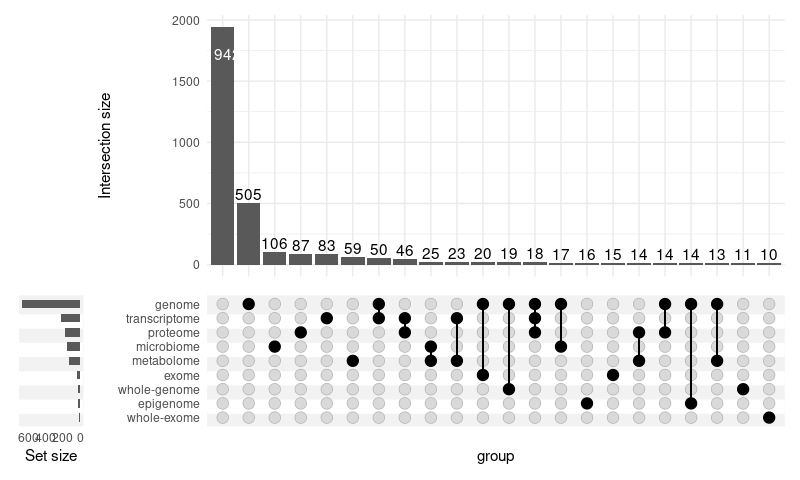

In [39]:
%%R -i ome_terms_mentioned -w 800 -r 100

upset(ome_terms_mentioned, colnames(ome_terms_mentioned), min_size=10, width_ratio=0.1)

[1] "Dropping 14 empty groups"


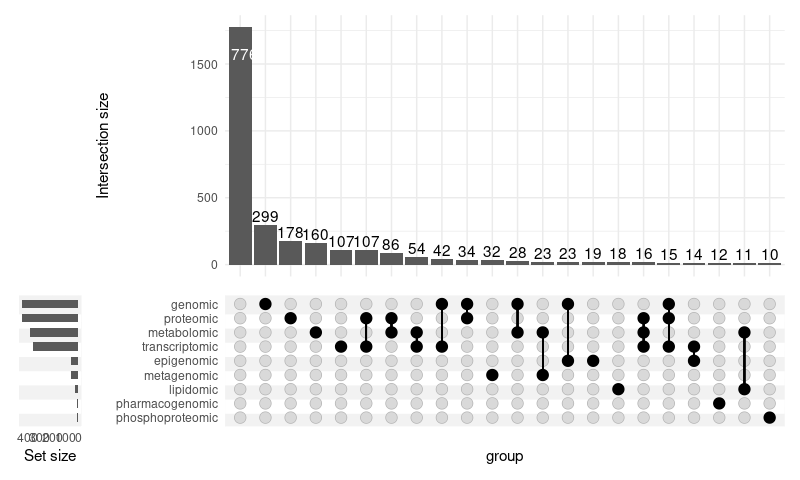

In [40]:
%%R -i omic_terms_mentioned -w 800 -r 100

upset(omic_terms_mentioned, colnames(omic_terms_mentioned), min_size=10, width_ratio=0.1)

## Merge -ome and -omic terms

In [41]:
from warnings import warn

terms_associated_with_omic = {
    omic + 's': [omic]
    for omic in omic_terms
}

for ome in ome_terms:
    assert ome.endswith('ome')
    auto_generate_omic_term = ome[:-3] + 'omics'
    omic = auto_generate_omic_term
    if omic not in terms_associated_with_omic:
        if omic in omic_counts.index:
            warn(f'{omic} was removed at thresholding, but it is a frequent -ome!')
        else:
            print(f'Creating omic {omic}')
        terms_associated_with_omic[omic] = []

    terms_associated_with_omic[omic].append(ome)

terms_associated_with_omic

Creating omic exomics
Creating omic whole-genomics
Creating omic whole-exomics
Creating omic interactomics
Creating omic secretomics
Creating omic translatomics
Creating omic whole-transcriptomics
Creating omic exposomics
Creating omic mirnomics
Creating omic host-microbiomics


{'proteomics': ['proteomic', 'proteome'],
 'genomics': ['genomic', 'genome'],
 'metabolomics': ['metabolomic', 'metabolome'],
 'transcriptomics': ['transcriptomic', 'transcriptome'],
 'metagenomics': ['metagenomic', 'metagenome'],
 'epigenomics': ['epigenomic', 'epigenome'],
 'lipidomics': ['lipidomic', 'lipidome'],
 'proteogenomics': ['proteogenomic'],
 'phosphoproteomics': ['phosphoproteomic', 'phosphoproteome'],
 'metaproteomics': ['metaproteomic', 'metaproteome'],
 'pharmacogenomics': ['pharmacogenomic'],
 'metatranscriptomics': ['metatranscriptomic', 'metatranscriptome'],
 'phenomics': ['phenomic', 'phenome'],
 'glycomics': ['glycomic'],
 'fluxomics': ['fluxomic'],
 'radiomics': ['radiomic'],
 'meta-omics': ['meta-omic'],
 'metabonomics': ['metabonomic'],
 'peptidomics': ['peptidomic'],
 'methylomics': ['methylomic', 'methylome'],
 'nutrigenomics': ['nutrigenomic'],
 'microbiomics': ['microbiomic', 'microbiome'],
 'glycoproteomics': ['glycoproteomic'],
 'exomics': ['exome'],
 'who

In [42]:
omics_by_entity = {
    'genes': {
        'genomics',
        'whole-genomics',
        'exomics',
        'whole-exomics'
    },
    'transcripts': {
        'transcriptomics',
        'whole-transcriptomics',
        'mirnomics',
        'translatomics'
    },
    'proteins & peptides': {
        'proteomics',
        # proteogenomics is basicaly protein/peptite identification
        # using genomic data, see https://doi.org/10.1038/nmeth.3144
        'proteogenomics',
        'peptidomics',
        'secretomics'
    },
    # could use a less common "environmental omics" term
    # just to avoid confusion when using "metaomics",
    # wich is often used to refer to a software tool,
    # or could even lead a non-expert to think that
    # metabolomics belongs in here
    'microbes (meta-omics)': {
        # for the sake of methods comparisons, the meta-*omic data are so different
        # (being a mix of thousands of organisms) that it warrants considering
        # those meta-Xomic as separate from Xomics (e.g. metagenomics as separate
        # from genomics)
        'metagenomics',
        'metatranscriptomics',
        'metaproteomics',
        'meta-omics',
        'microbiomics',
        'host-microbiomics'
    },
    'epigenetic modifications': {
        'epigenomics',
        'methylomics'
    },
    'protein modifications': {
        'glycoproteomics',
        'phosphoproteomics',
    },
    'exogenous factors': {
        'exposomics',
        'pharmacogenomics',
        'nutrigenomics'
    },
    'endogenous metabonomics': {
        'metabonomics',
        'lipidomics',
        'metabolomics',
        'glycomics',
        'fluxomics'
    },
    'clinical data': {
        'radiomics',
        'phenomics'
    }
}

omics_by_entity_group = {
    'proteins, peptides & modifications': {
        *omics_by_entity['proteins & peptides'],
        *omics_by_entity['protein modifications']
    },
    'metabonomics': {
        *omics_by_entity['endogenous metabonomics'],
        'exposomics'
    },
    'genes, epigenetics & genetic associations': {
        *omics_by_entity['genes'],
        *omics_by_entity['epigenetic modifications'],
        'pharmacogenomics',
        'nutrigenomics',
    },
    'microbes (meta-omics)': omics_by_entity['microbes (meta-omics)'],
    'transcripts': omics_by_entity['transcripts'],
    'clinical data': omics_by_entity['clinical data']
}

In [43]:
from functools import reduce
omics_mapped_to_entities = reduce(set.union, omics_by_entity.values())
set(terms_associated_with_omic) - omics_mapped_to_entities

{'interactomics'}

In [44]:
assert omics_mapped_to_entities - set(terms_associated_with_omic) == set()

In [45]:
omics_mapped_to_entities_groups = reduce(set.union, omics_by_entity_group.values())
set(terms_associated_with_omic) - omics_mapped_to_entities_groups

{'interactomics'}

In [46]:
from omics import add_entities_to_features


add_entities_to_omic_features = partial(
    add_entities_to_features,
    features=omics_features,
    omics_terms=terms_associated_with_omic
)

In [47]:
omics = {k: [k] for k in terms_associated_with_omic}
add_entities_to_omic_features(omics, entity_type='ome_or_omic')

,ome_or_omic,terms
0,proteomics,"[proteome, proteomic]"
1,genomics,"[genome, genomic]"
2,metabolomics,"[metabolome, metabolomic]"
3,transcriptomics,"[transcriptome, transcriptomic]"
4,metagenomics,"[metagenome, metagenomic]"
5,epigenomics,"[epigenome, epigenomic]"
6,lipidomics,"[lipidome, lipidomic]"
7,proteogenomics,[proteogenomic]
8,phosphoproteomics,"[phosphoproteome, phosphoproteomic]"
9,metaproteomics,"[metaproteome, metaproteomic]"


In [48]:
add_entities_to_omic_features(omics_by_entity, entity_type='entity')

,entity,terms
0,genes,"[exome, genome, genomic, whole-exome, whole-genome]"
1,transcripts,"[mirnome, transcriptome, transcriptomic, translatome, whole-transcriptome]"
2,proteins & peptides,"[peptidomic, proteogenomic, proteome, proteomic, secretome]"
3,microbes (meta-omics),"[host-microbiome, meta-omic, metagenome, metagenomic, metaproteome, metaproteomic, metatranscrip..."
4,epigenetic modifications,"[epigenome, epigenomic, methylome, methylomic]"
5,protein modifications,"[glycoproteomic, phosphoproteome, phosphoproteomic]"
6,exogenous factors,"[exposome, nutrigenomic, pharmacogenomic]"
7,endogenous metabonomics,"[fluxomic, glycomic, lipidome, lipidomic, metabolome, metabolomic, metabonomic]"
8,clinical data,"[phenome, phenomic, radiomic]"


In [49]:
add_entities_to_omic_features(omics_by_entity_group, entity_type='entity_group')

,entity_group,terms
0,"proteins, peptides & modifications","[glycoproteomic, peptidomic, phosphoproteome, phosphoproteomic, proteogenomic, proteome, proteom..."
1,metabonomics,"[exposome, fluxomic, glycomic, lipidome, lipidomic, metabolome, metabolomic, metabonomic]"
2,"genes, epigenetics & genetic associations","[epigenome, epigenomic, exome, genome, genomic, methylome, methylomic, nutrigenomic, pharmacogen..."
3,microbes (meta-omics),"[host-microbiome, meta-omic, metagenome, metagenomic, metaproteome, metaproteomic, metatranscrip..."
4,transcripts,"[mirnome, transcriptome, transcriptomic, translatome, whole-transcriptome]"
5,clinical data,"[phenome, phenomic, radiomic]"


### Visualize the entities & entities groups

In [50]:
omic_entities = omics_features['entity_' + Series(list(omics_by_entity.keys()))].rename(columns=prefix_remover('entity_'))
omic_entities_groups = omics_features['entity_group_' + Series(list(omics_by_entity_group.keys()))].rename(columns=prefix_remover('entity_group_'))

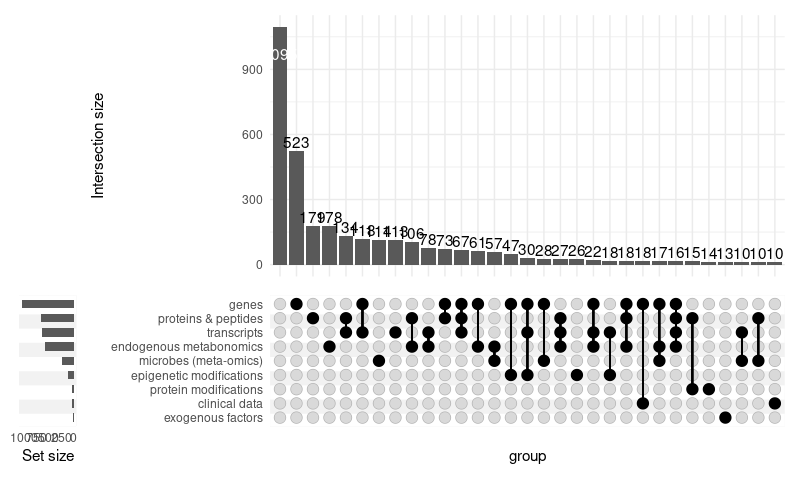

In [51]:
%%R -i omic_entities -w 800 -r 100

upset(omic_entities, colnames(omic_entities), min_size=10, width_ratio=0.1)

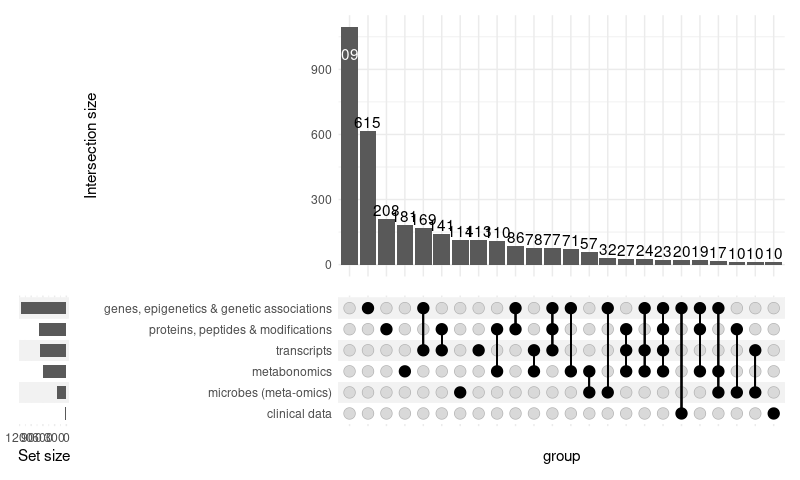

In [52]:
%%R -i omic_entities_groups -w 800 -r 100

upset(omic_entities_groups, colnames(omic_entities_groups), min_size=10, width_ratio=0.1)

### Number of omics mentioned in abstract vs the multi-omic term used

In [53]:
omes_or_omics_df = omics_features['ome_or_omic_' + Series(list(omics.keys()))].rename(columns=prefix_remover('ome_or_omic_'))

In [54]:
literature['omic_terms_in_abstract'] = omes_or_omics_df.sum(axis=1)

In [55]:
lt = literature[['term', 'omic_terms_in_abstract']]

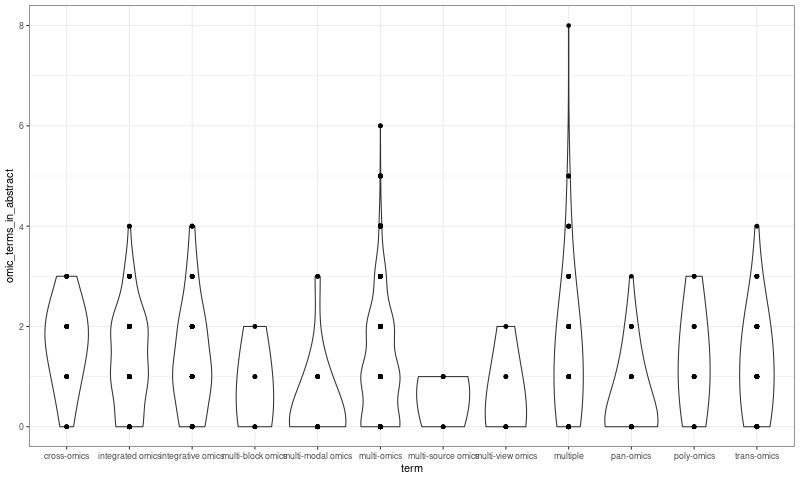

In [56]:
%%R -i lt -w 800
(
    ggplot(lt, aes(x=term, y=omic_terms_in_abstract))
    + geom_violin(adjust=2)
    + geom_point()
    + theme_bw()
)

# Current limitations

## Patchy coverage

Currently I only detected omic-describing terms in less than 70% of abstracts:

In [57]:
omic_entities.any(axis=1).mean()

0.6728413504631013

Potential solution: select a random sample of 50 articles, annotate manually, calculate sensitivity and specificity.

If any omic is consistently omitted, reconsider how search terms are created.

## Apostrophes

Are we missing out on \*'omic terms, such us meta'omic used in [here](https://doi.org/10.1053/j.gastro.2014.01.049)?

In [58]:
check_usage_in_abstracts(
    r'\w+\'omic',
    words=False,
    highlight='\'omic'
)

uid
31142855    lable through the Inflammatory Bowel Disease Multi'omics Database ( http://ibdmdb.org ), provide...
32612960    ght and weight of our cohort. We performed a multi'omics [i.e., 16S rRNA amplicon and shotgun me...
Name: abstract_clean, dtype: object

unlikely (but would be nice to get it in!)

## Fields of study

In [59]:
'genetics', 'epigenetics'

('genetics', 'epigenetics')

Some authors may prefer to say "we integrated genetic and proteomic data" rather than "genomic and proteomic"